### Imports and functions

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# from google.cloud import storage

# client = storage.Client()
# for blob in client.list_blobs('climateai_data_repository', prefix='tmp/internal_variability'):
#   print(str(blob))

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import intake 
import pprint
from src.LE_LoadAndMerge import *
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from copy import deepcopy

In [4]:
def sensitivity_test(parameter,region,args):
    values = args[parameter]
    datasets = []
    for i in values:
        args[parameter] = i
        internal = region.extreme_internal_variability(**args)
        datasets.append(internal)
    dataset = xr.concat(datasets, dim=values)
    dataset['MTratio'] = dataset.model_le/dataset.total_le
        
    return dataset

In [42]:
def sensitivity_allregions(parameter, args):
    regions = [USeast,USwest,iceland,europe,australia,tropics]
    dss = []
    for r in regions:
        tmp_args = deepcopy(args)
        ds = sensitivity_test(parameter=parameter,region=r,args=tmp_args)
        ds = ds.expand_dims('region')
        dss.append(ds)
    regions = ['USeast','USwest','iceland','europe','australia','tropics']
    final_dataset = xr.concat(dss,dim='region')
    final_dataset = final_dataset.assign_coords({'region':regions})
    
    return final_dataset

### Load Datasets

In [53]:
# settings 
#for temp
# variable = 'tas'
# models = ['CanESM5','cesm_lens','MIROC6','MPI-ESM1-2-LR','EC-Earth3'] 

#for precip - still having issues getting EC-Earth data 
variable = 'pr'
models = ['CanESM5','cesm_lens','MIROC6','MPI-ESM1-2-LR'] 

In [54]:
USeast = MultiModelLargeEnsemble(models=models,
                                 variable=variable, granularity='day', lat=41.3, 
                                 lon=-72.5,bucket='climateai_data_repository', 
                                 path='tmp/internal_variability',
                                 return_period=10, hist_slice=slice('1995','2014'),
                                 coarsen=7, conseq_days=1, rolling_average = 10,
                                 load=True)

In [55]:
USwest = MultiModelLargeEnsemble(models=models,
                                 variable=variable, granularity='day', lat=37.7, lon=-122.4,
                                 bucket='climateai_data_repository', 
                                 path='tmp/internal_variability',
                                 return_period=10, hist_slice=slice('1995','2014'),
                                 coarsen=7, conseq_days=1, rolling_average = 10,
                                 load=True)

In [56]:
iceland = MultiModelLargeEnsemble(models=models,
                                 variable=variable, granularity='day', lat=65, lon=-19,
                                 bucket='climateai_data_repository', 
                                 path='tmp/internal_variability',
                                 return_period=10, hist_slice=slice('1995','2014'),
                                 coarsen=7, conseq_days=1, rolling_average = 10,
                                 load=True)

In [57]:
europe = MultiModelLargeEnsemble(models=models,
                                 variable=variable, granularity='day', lat=51,lon=10.5,
                                 bucket='climateai_data_repository', 
                                 path='tmp/internal_variability',
                                 return_period=10, hist_slice=slice('1995','2014'),
                                 coarsen=7, conseq_days=1, rolling_average = 10,
                                 load=True)

In [58]:
australia = MultiModelLargeEnsemble(models=models,
                                 variable=variable, granularity='day', lat=-25.2,lon=133.7,
                                 bucket='climateai_data_repository', 
                                 path='tmp/internal_variability',
                                 return_period=10, hist_slice=slice('1995','2014'),
                                 coarsen=7, conseq_days=1, rolling_average = 10,
                                 load=True)

In [59]:
tropics = MultiModelLargeEnsemble(models=models,
                                 variable=variable, granularity='day', lat=3.9,lon=-53.1,
                                 bucket='climateai_data_repository', 
                                 path='tmp/internal_variability',
                                 return_period=10, hist_slice=slice('1995','2014'),
                                 coarsen=7, conseq_days=1, rolling_average = 10,
                                 load=True)

### sensitivity testing
using model:internal ratio for testing the various parameters. When ratio > 1, model uncertainty dominates. When ratio < 1, internal variability dominates. 

### Return periods 

In [11]:
args = {'return_period':[5,10,15,20,25,30, 50, 75, 100, 200],
        'coarsen':1,
        'conseq_days':1,
        'rolling_average':10,
        'hist_slice':slice('1995','2014')
       }

In [12]:
tmp_args = deepcopy(args)

In [13]:
tmp_args

{'return_period': [5, 10, 15, 20, 25, 30, 50, 75, 100, 200],
 'coarsen': 1,
 'conseq_days': 1,
 'rolling_average': 10,
 'hist_slice': slice('1995', '2014', None)}

In [14]:
args

{'return_period': [5, 10, 15, 20, 25, 30, 50, 75, 100, 200],
 'coarsen': 1,
 'conseq_days': 1,
 'rolling_average': 10,
 'hist_slice': slice('1995', '2014', None)}

In [15]:
USeast_return = sensitivity_test(region=USeast,parameter='return_period',args=tmp_args)
# USwest_return = sensitivity_test(region=USwest,parameter='return_period',args=args)
# iceland_return = sensitivity_test(region=iceland,parameter='return_period',args=args)

In [16]:
tmp_args

{'return_period': 200,
 'coarsen': 1,
 'conseq_days': 1,
 'rolling_average': 10,
 'hist_slice': slice('1995', '2014', None)}

In [60]:
test_return = sensitivity_allregions(parameter='return_period',
                                     args = {'return_period':[5,10,15,20,25,30, 50, 75, 100, 200],
                                                'coarsen':1,
                                                'conseq_days':1,
                                                'rolling_average':10,
                                                'hist_slice':slice('1995','2014')
                                               })

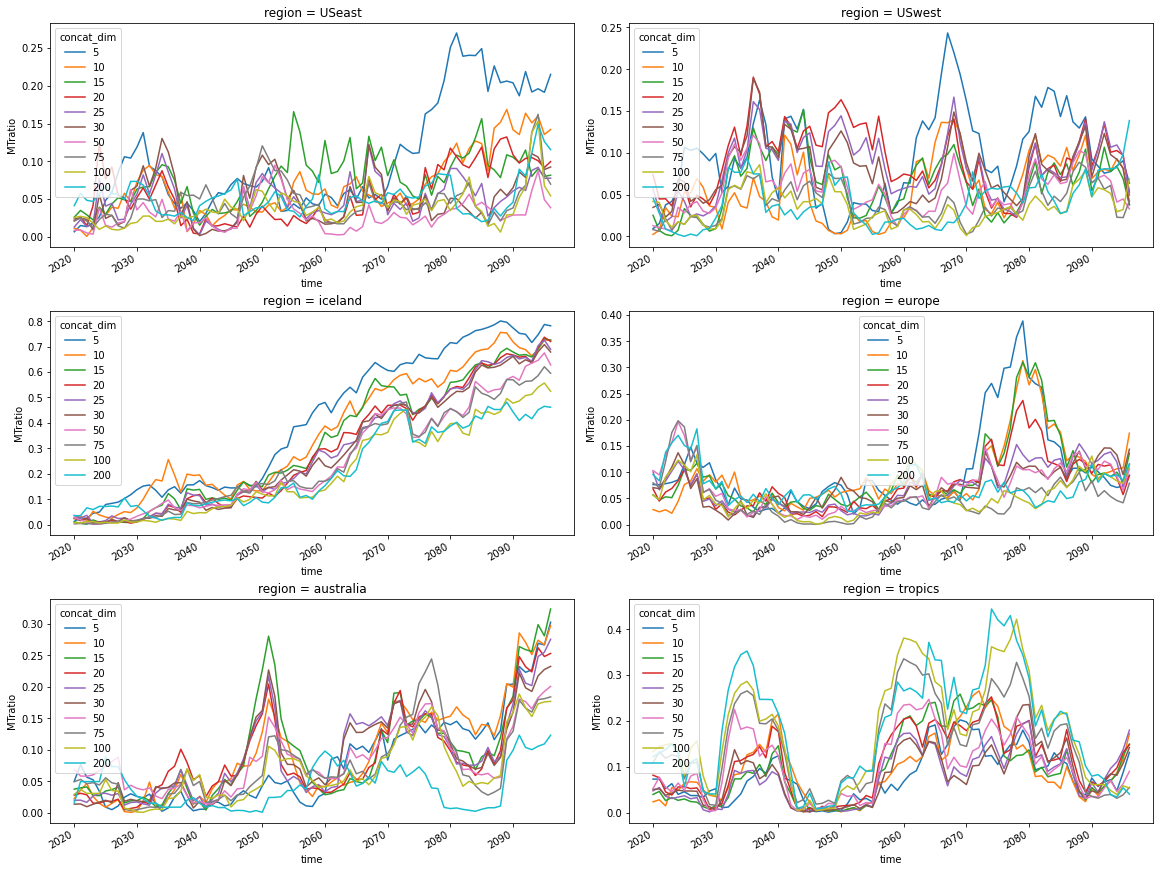

In [61]:
fig,ax = plt.subplots(nrows=3,ncols=2,constrained_layout=True,figsize=(16,12))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1],ax[2,0],ax[2,1]]
regions = ['USeast','USwest','iceland','europe','australia','tropics']
for axe,r in zip(axes,regions):
    test_return.sel(region=r).MTratio.plot(hue='concat_dim',ax=axe);

### Hist_slice

In [62]:
test_histslice = sensitivity_allregions(parameter='hist_slice',
                                        args = {'return_period':10,
                                                'coarsen':1,
                                                'conseq_days':1,
                                                'rolling_average':10,
                                                'hist_slice':[slice('1920','1940'),slice('1940','1960'),slice('1960','1980'),
                                                              slice('1990','2010'),slice('1995','2014'),slice('1930','1950'),
                                                              slice(None, None), slice('1990', None)]}
                                       )

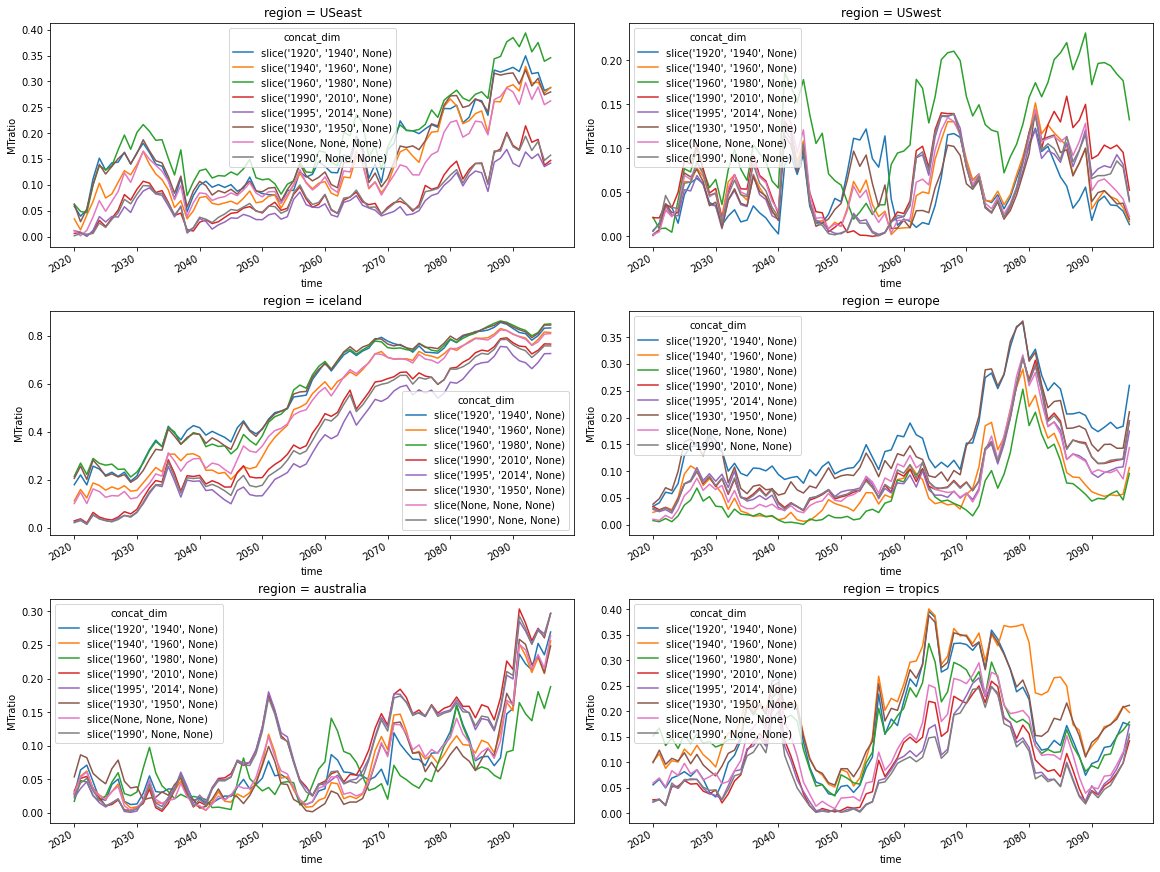

In [63]:
fig,ax = plt.subplots(nrows=3,ncols=2,constrained_layout=True,figsize=(16,12))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1],ax[2,0],ax[2,1]]
regions = ['USeast','USwest','iceland','europe','australia','tropics']
for axe,r in zip(axes,regions):
    test_histslice.sel(region=r).MTratio.plot(hue='concat_dim',ax=axe);

### coarsen

In [64]:
test_coarsen = sensitivity_allregions(parameter='coarsen',
                                    args = {'return_period':10,
                                            'coarsen':[1,2,3,4,5,6,7],
                                            'conseq_days':1,
                                            'rolling_average':10,
                                            'hist_slice':slice('1995','2014')
                                           })

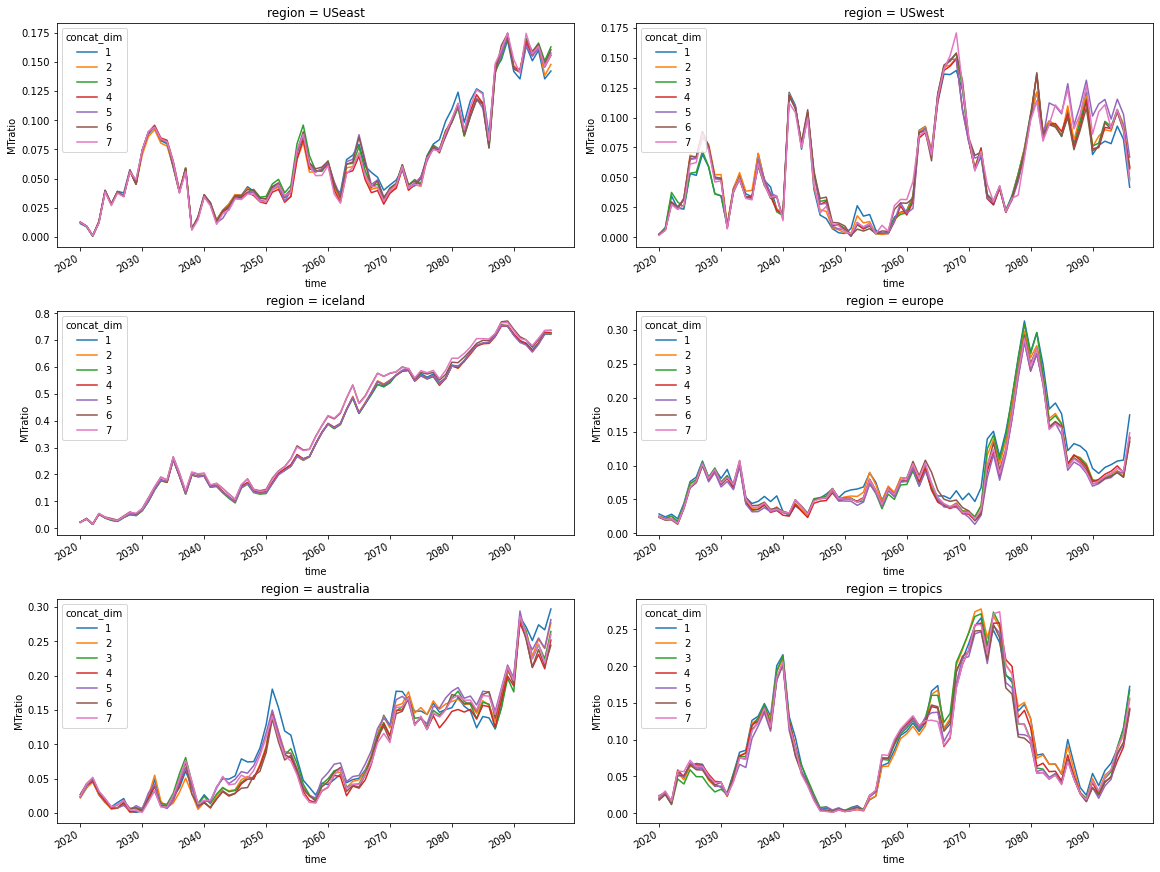

In [65]:
fig,ax = plt.subplots(nrows=3,ncols=2,constrained_layout=True,figsize=(16,12))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1],ax[2,0],ax[2,1]]
regions = ['USeast','USwest','iceland','europe','australia','tropics']
for axe,r in zip(axes,regions):
    test_coarsen.sel(region=r).MTratio.plot(hue='concat_dim',ax=axe);

### Consecutive days 

In [66]:
test_conseq = sensitivity_allregions(parameter='conseq_days',
                       args= {'return_period':10,
                              'coarsen':7,
                              'conseq_days':[1,2,3,4,5,6],
                              'rolling_average':10,
                              'hist_slice':slice('1995','2014')
                             }
                      )

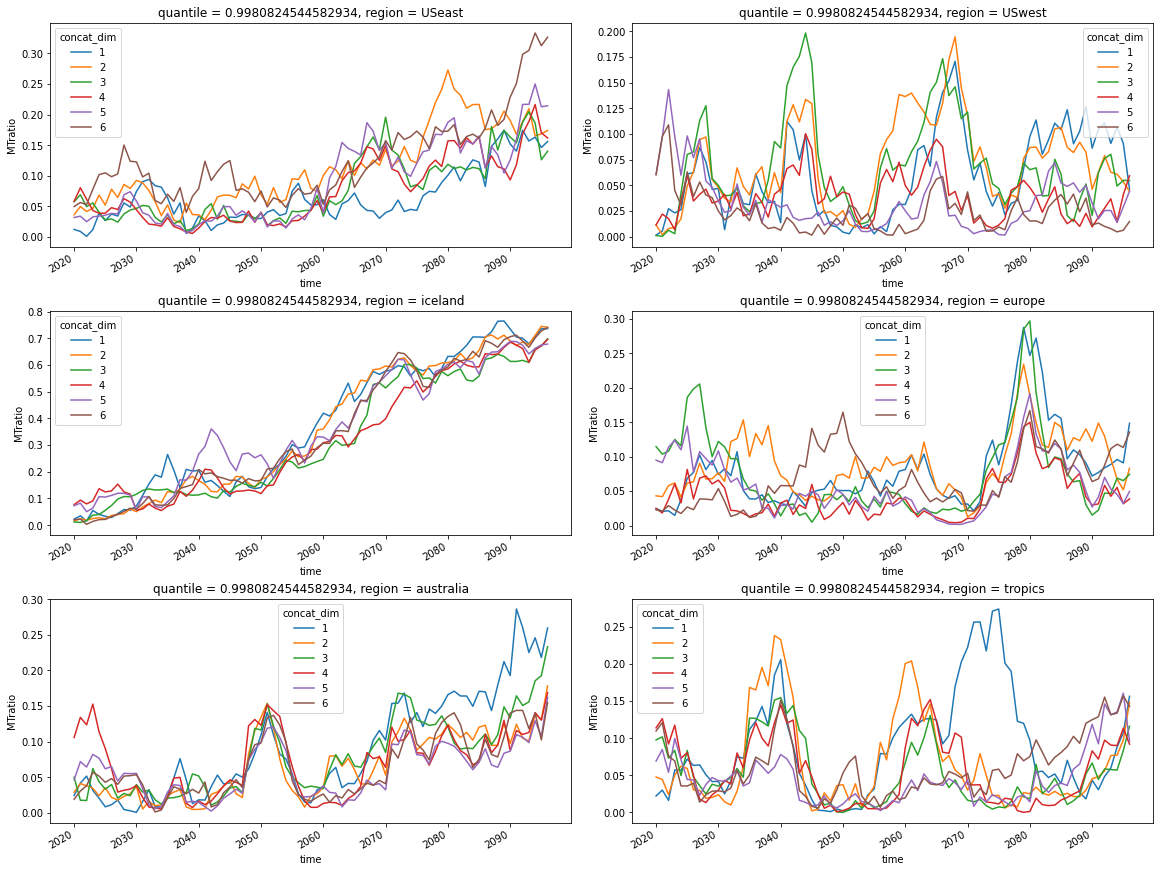

In [67]:
fig,ax = plt.subplots(nrows=3,ncols=2,constrained_layout=True,figsize=(16,12))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1],ax[2,0],ax[2,1]]
regions = ['USeast','USwest','iceland','europe','australia','tropics']
for axe,r in zip(axes,regions):
    test_conseq.sel(region=r).MTratio.plot(hue='concat_dim',ax=axe);

### rolling average

In [68]:
test_rolling = sensitivity_allregions(parameter='rolling_average',
                                        args = {'return_period':10,
                                                'coarsen':1,
                                                'conseq_days':1,
                                                'rolling_average':[1,5,10,15,20,25],
                                                'hist_slice':slice('1995','2014')
                                               }
                                     )

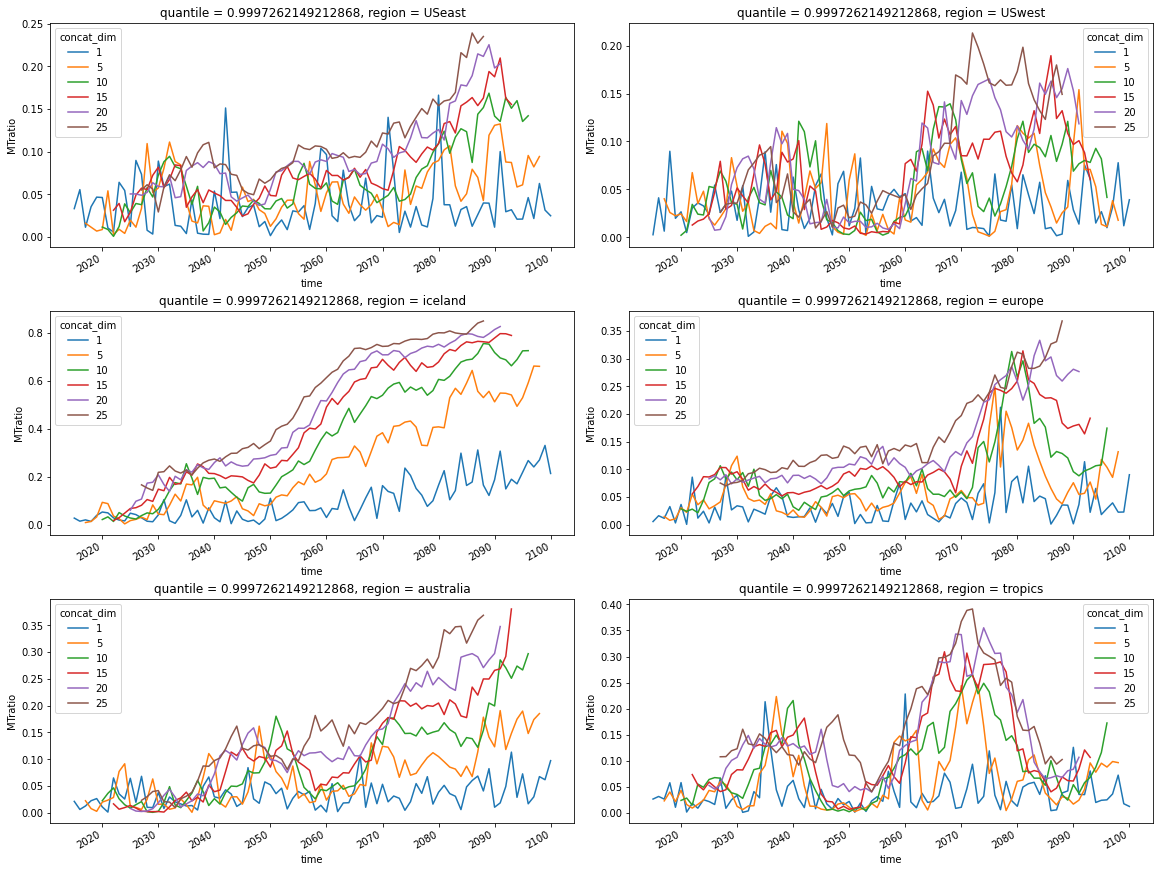

In [69]:
fig,ax = plt.subplots(nrows=3,ncols=2,constrained_layout=True,figsize=(16,12))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1],ax[2,0],ax[2,1]]
regions = ['USeast','USwest','iceland','europe','australia','tropics']
for axe,r in zip(axes,regions):
    test_rolling.sel(region=r).MTratio.plot(hue='concat_dim',ax=axe);